## **Environment Preparation**

**Install bigdl-chronos**

You can install the latest pre-release version with automl support using `pip install --pre --upgrade bigdl-chronos[all]`. 

In [ ]:
# Install latest pre-release version of bigdl-chronos 
# Installing bigdl-chronos from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-chronos[all]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict
exit() # restart the runtime to refresh installed pkg

In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.20.1

!pip uninstall pandas -y
!pip install pandas==1.2.2
exit()

## **Distributed automl for time series forecasting using Chronos AutoTS**

In this guide we will demonstrate how to use Chronos AutoTS for automated time seires forecasting in 5 simple steps.

## **Problem 1: Predict WindSpeed by Hour**


In [1]:
# load the dataset. The downloaded dataframe contains two columns, "timestamp" and "value".
import pandas as pd
#Download TEST dataset
!git clone https://github.com/callmeJ274/Wind_time_series_Datasets.git

fatal: destination path 'Wind_time_series_Datasets' already exists and is not an empty directory.


In [2]:
df_ = pd.read_csv('/content/Wind_time_series_Datasets/data_/Wind Time Series Dataset(hourly).csv') # We're gonna experiment this
df_[['Time']] = df_[['Time']].apply(pd.to_datetime)

### **Step 1: Init Orca Context** 

In [3]:
# import necesary libraries and modules
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details. Note that argument ```init_ray_on_spark``` must be ```True``` for Chronos.

In [4]:
# recommended to set it to True when running bigdl-chronos in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

init_orca_context(cluster_mode="local", cores=4, init_ray_on_spark=True)

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
2021-12-19 03:42:01 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).

User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   K

cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.Sample
BigDLBasePickler registering: bigdl.dllib.utils.common  Sample
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.dllib.utils.common  EvaluatedResult
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.JTensor
BigDLBasePickler registering: bigdl.dllib.utils.common  JTensor
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.JActivity
BigDLBasePickler registering: bigdl.dllib.utils.common  JActivity
Successfully got a SparkContext


2021-12-19 03:42:06,261	INFO services.py:1174 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2021-12-19_03-42-05_411428_485/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2021-12-19_03-42-05_411428_485/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2021-12-19_03-42-05_411428_485', 'metrics_export_port': 50173, 'node_id': 'e82e96da071b9ae26429e2ff540c0c26f9a2d092c0579effa0c5176b'}


<SparkContext master=local[4] appName=pyspark-shell>

### **Step 2: Data transformation and feature engineering using Chronos TSDataset**
[TSDataset](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html) is our abstract of time series dataset for data transformation and feature engineering. Here we use it to preprocess the data.

In [5]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df_, # the dataframe to load
                                                              dt_col="Time",  # the column name specifying datetime
                                                              target_col="WindSpeed", # the column name to predict
                                                              with_split=True, # split the dataset into 3 parts
                                                              val_ratio=0.1, # validation set ratio
                                                              test_ratio=0.1) # test set ratio

# for each tsdataset, we 
# 1. generate datetime feature columns.
# 2. impute the dataset with last occured value.
# 3. scale the dataset with standard scaler, fit = true for train data.
standard_scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
    tsdata.gen_dt_feature(features = 'all')\
          .impute(mode="last")\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Step 3: Create an AutoTSEstimator**


[AutoTSEstimator](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/autotsestimator.html) is our Automated TimeSeries Estimator for time series forecasting task.

In [6]:
import bigdl.orca.automl.hp as hp
from bigdl.chronos.autots import AutoTSEstimator
auto_estimator = AutoTSEstimator(model='tcn', # the model name used for training
                                 search_space='normal', # a default hyper parameter search space
                                 past_seq_len=hp.randint(1, 10)) # hp sampling function of past_seq_len for auto-tuning

### **Step 4: Fit with AutoTSEstimator**

In [7]:
# fit with AutoTSEstimator for a returned TSPipeline
ts_pipeline = auto_estimator.fit(data=tsdata_train, # train dataset
                                 validation_data=tsdata_val, # validation dataset
                                 epochs=5) # number of epochs to train in each trial

2021-12-19 03:51:24,893	INFO tune.py:450 -- Total run time: 498.77 seconds (498.41 seconds for the tuning loop).
/usr/local/lib/python3.7/dist-packages/bigdl/nano/pytorch/onnx/onnxrt_inference.py:197: UserWarning: on_fit_start method/property will be replaced.
  warnings.warn(f"{component} method/property will be replaced.")


### **Step 5: Further deployment with TSPipeline**

[TSPipeline](https://analytics-zoo.readthedocs.io/en/latest/doc/PythonAPI/Chronos/autotsestimator.html#tspipeline-experimental) is our E2E solution for time series forecasting task.

In [8]:
# predict with the best trial
y_pred = ts_pipeline.predict(tsdata_test)

In [9]:
# evaluate the result pipeline
mse, smape = ts_pipeline.evaluate(tsdata_test, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 0.9297936267564346
Evaluate: the smape value is 0.1103663432788855


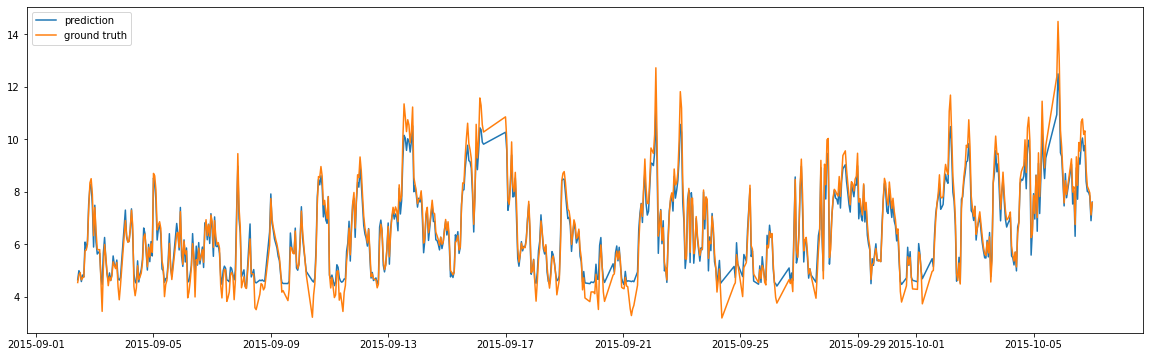

In [10]:
# plot the result
import matplotlib.pyplot as plt

lookback = auto_estimator.get_best_config()['past_seq_len']
groundtruth_unscale = tsdata_test.unscale().to_pandas()[lookback - 1:]

plt.figure(figsize=(20,6))
plt.plot(groundtruth_unscale["Time"], y_pred[:,0,0])
plt.plot(groundtruth_unscale["Time"], groundtruth_unscale[['WindSpeed']])
plt.legend(["prediction", "ground truth"])

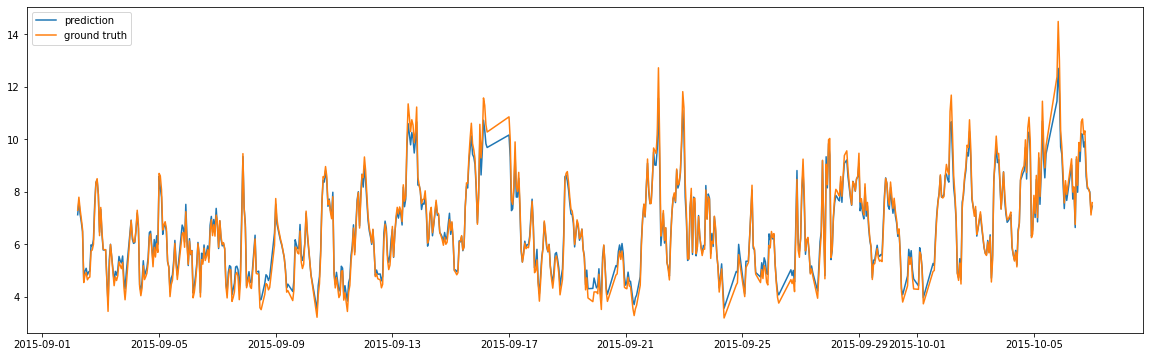

In [ ]:
# Đây là bản cũ thôi!!!
#import matplotlib.pyplot as plt

#lookback = auto_estimator.get_best_config()['past_seq_len']
#groundtruth_unscale = tsdata_test.unscale().to_pandas()[lookback - 1:]

#plt.figure(figsize=(20,6))
#plt.plot(groundtruth_unscale["Time"], y_pred[:,0,0])
#plt.plot(groundtruth_unscale["Time"], groundtruth_unscale[['WindSpeed']])
#plt.legend(["prediction", "ground truth"])

In [ ]:
# save the pipeline
#my_ppl_file_path = "/tmp/saved_pipeline"
#ts_pipeline.save(my_ppl_file_path)

In [ ]:
# restore the pipeline for further deployment
#from bigdl.chronos.autots import TSPipeline
#loaded_ppl = TSPipeline.load(my_ppl_file_path)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12466740359704308 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/bigdl/nano/pytorch/onnx/onnxrt_inference.py:197: UserWarning: on_fit_start method/property will be replaced.
  warnings.warn(f"{component} method/property will be replaced.")


In [11]:
# Stop orca context when your program finishes
stop_orca_context()

Stopping orca context


## **Problem 2: WindSpeed + Time -> Power**


### **Step 1: Init Orca Context** 

In [22]:
# import necesary libraries and modules
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details. Note that argument ```init_ray_on_spark``` must be ```True``` for Chronos.

In [13]:
# recommended to set it to True when running bigdl-chronos in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

init_orca_context(cluster_mode="local", cores=4, init_ray_on_spark=True)

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


2021-12-19 03:51:35,321	INFO services.py:1174 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2021-12-19_03-51-34_796763_485/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2021-12-19_03-51-34_796763_485/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2021-12-19_03-51-34_796763_485', 'metrics_export_port': 61317, 'node_id': 'f8376d2ceb45401ce4ccf11107e776d2f8efb1f7029c33fac1ee6f85'}


<SparkContext master=local[4] appName=pyspark-shell>

### **Step 2: Data transformation and feature engineering using Chronos TSDataset**
[TSDataset](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html) is our abstract of time series dataset for data transformation and feature engineering. Here we use it to preprocess the data.

Appoint time features: MINUTE, HOUR, DAY, MONTH, YEAR: but when fitting, model only chose MINUTE, MONTH, YEAR???

In [14]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df_, # the dataframe to load
                                                              dt_col="Time",  # the column name specifying datetime
                                                              target_col="Power", # the column name to predict
                                                              extra_feature_col = 'WindSpeed',
                                                              with_split=True, # split the dataset into 3 parts
                                                              val_ratio=0.1, # validation set ratio
                                                              test_ratio=0.1) # test set ratio

# for each tsdataset, we 
# 1. generate datetime feature columns.
# 2. impute the dataset with last occured value.
# 3. scale the dataset with standard scaler, fit = true for train data.
standard_scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
    tsdata.gen_dt_feature(features = 'all')\
          .impute(mode="last")\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))

### **Step 3: Create an AutoTSEstimator**


[AutoTSEstimator](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/autotsestimator.html) is our Automated TimeSeries Estimator for time series forecasting task.

In [15]:
import bigdl.orca.automl.hp as hp
from bigdl.chronos.autots import AutoTSEstimator
auto_estimator = AutoTSEstimator(model='tcn', # the model name used for training
                                 search_space='normal', # a default hyper parameter search space
                                 past_seq_len=hp.randint(1, 10)) # hp sampling function of past_seq_len for auto-tuning

### **Step 4: Fit with AutoTSEstimator**

In [16]:
# fit with AutoTSEstimator for a returned TSPipeline
ts_pipeline = auto_estimator.fit(data=tsdata_train, # train dataset
                                 validation_data=tsdata_val, # validation dataset
                                 epochs=5) # number of epochs to train in each trial

2021-12-19 03:59:57,219	INFO tune.py:450 -- Total run time: 496.86 seconds (496.80 seconds for the tuning loop).
/usr/local/lib/python3.7/dist-packages/bigdl/nano/pytorch/onnx/onnxrt_inference.py:197: UserWarning: on_fit_start method/property will be replaced.
  warnings.warn(f"{component} method/property will be replaced.")


### **Step 5: Further deployment with TSPipeline**

[TSPipeline](https://analytics-zoo.readthedocs.io/en/latest/doc/PythonAPI/Chronos/autotsestimator.html#tspipeline-experimental) is our E2E solution for time series forecasting task.

In [17]:
# predict with the best trial
y_pred = ts_pipeline.predict(tsdata_test)

In [18]:
# evaluate the result pipeline
mse, smape = ts_pipeline.evaluate(tsdata_test, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 142.8073903839445
Evaluate: the smape value is 0.4337274221890665


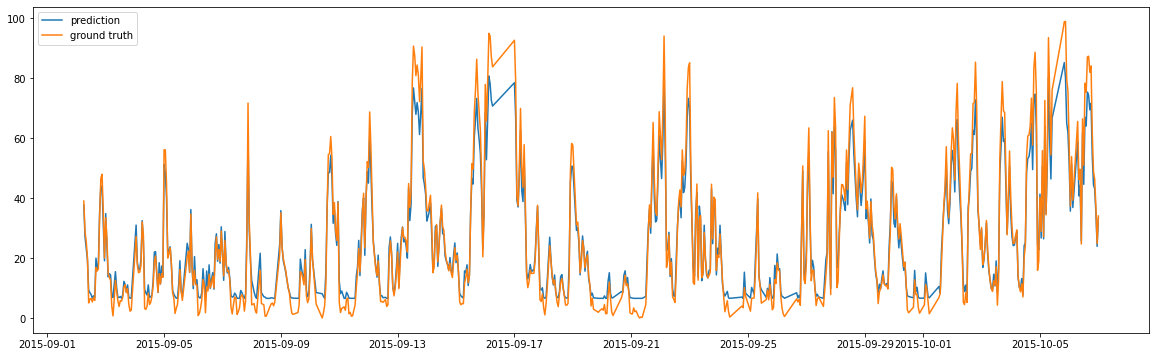

In [19]:
# plot the result
import matplotlib.pyplot as plt

lookback = auto_estimator.get_best_config()['past_seq_len']
groundtruth_unscale = tsdata_test.unscale().to_pandas()[lookback - 1:]

plt.figure(figsize=(20,6))
plt.plot(groundtruth_unscale["Time"], y_pred[:,0,0])
plt.plot(groundtruth_unscale["Time"], groundtruth_unscale[['Power']])
plt.legend(["prediction", "ground truth"])

In [20]:
# Stop orca context when your program finishes
stop_orca_context()

Stopping orca context
